### Scraping average monthly temperatures in every state of United States

The code below scrapes the Internet site (https://www.usclimatedata.com) to find the average temperature in every month and every state of the United States of America. Provided data uses Fahrenheit degrees.


Since natural gas is used (among others) for heating houses in the winter and also for electricity production and indirectly cooling in the summer, some (probably non-linear) dependence between the temperatures and the gas prices might occur.

In [15]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Function 'Scrape_US_temperatures' scrapes the website and saves data as a dataframe.

In [16]:
def Scrape_US_temperatures(print_results = True):
    
    'returns "temps" dataframe with historical average low temperatures for each month and each US state'
    
    url = 'https://www.usclimatedata.com'
    answer = requests.get(url)
    website = answer.text
    soup = BeautifulSoup(website, 'html.parser')
    global temps
    temps = []
    states_names = []
    
    for link in soup.findAll('a', {'class': 'stretched-link'}):
        
        url_state = (f"{url}{link.get('href')}")
        answer_state = requests.get(url_state)
        website_state = answer_state.text
        soup_state = BeautifulSoup(website_state, 'html.parser')
        if print_results == True:
            print(url_state)
            
        my_table = soup_state.findAll('td', {'class':"low text-right"})
        
        temps_low = []

        for row in my_table:
            temps_low.append(int(re.findall('\d+', str(row))[0]))
            
        if print_results == True:
            print(temps_low)
            print(' ')
            
        temps.append(temps_low)
        
        states_names.append(f'''{re.findall('^.+climate/(.+)/united.+',
                            f'{url}{link.get("href")}')[0].capitalize()}_low_t''')
        
    temps = pd.DataFrame(temps).T
    temps.columns = states_names

In [21]:
# Calling this function will create the 'temps' dataframe and by default print the average temperatures per state.
# Please note that the website contains both average low and average high temperatures - the function scrapes
# lows only as they seem to be more important in terms of heating demand.
Scrape_US_temperatures()

https://www.usclimatedata.com/climate/alabama/united-states/3170
[34, 37, 44, 51, 60, 68, 71, 71, 64, 53, 44, 36]
 
https://www.usclimatedata.com/climate/alaska/united-states/3171
[11, 14, 19, 29, 40, 48, 52, 50, 42, 29, 17, 13]
 
https://www.usclimatedata.com/climate/arizona/united-states/3172
[46, 49, 53, 60, 69, 78, 83, 83, 77, 65, 53, 45]
 
https://www.usclimatedata.com/climate/arkansas/united-states/3173
[32, 35, 43, 51, 61, 69, 73, 72, 65, 53, 42, 34]
 
https://www.usclimatedata.com/climate/california/united-states/3174
[39, 41, 44, 46, 51, 56, 58, 58, 56, 50, 43, 38]
 
https://www.usclimatedata.com/climate/colorado/united-states/3175
[18, 19, 27, 34, 43, 52, 59, 57, 48, 37, 25, 18]
 
https://www.usclimatedata.com/climate/connecticut/united-states/3176
[23, 25, 31, 41, 51, 60, 66, 66, 58, 47, 38, 28]
 
https://www.usclimatedata.com/climate/delaware/united-states/3177
[27, 29, 36, 44, 54, 63, 68, 67, 60, 49, 40, 31]
 
https://www.usclimatedata.com/climate/district-of-columbia/unit

In [20]:
temps

Alabama_low_t  Alaska_low_t  Arizona_low_t  Arkansas_low_t  \
0              34            11             46              32   
1              37            14             49              35   
2              44            19             53              43   
3              51            29             60              51   
4              60            40             69              61   
5              68            48             78              69   
6              71            52             83              73   
7              71            50             83              72   
8              64            42             77              65   
9              53            29             65              53   
10             44            17             53              42   
11             36            13             45              34   

    California_low_t  Colorado_low_t  Connecticut_low_t  Delaware_low_t  \
0                 39              18                 23              27   
1                 41              19                 25              29   
2                 44              27                 31              36   
3                 46              34                 41              44   
4                 51              43                 51              54   
5                 56              52                 60              63   
6                 58              59                 66              68   
7                 58              57                 66              67   
8                 56              48                 58              60   
9                 50              37                 47              49   
10                43              25                 38              40   
11                38              18                 28              31   

    District-of-columbia_low_t  Florida_low_t  ...  South-dakota_low_t  \
0                           27             39  ...                   0   
1                           28             42  ...                   5   
2                           35             47  ...                  19   
3                           44             52  ...                  32   
4                           54             62  ...                  45   
5                           63             69  ...                  55   
6                           68             72  ...                  60   
7                           66             72  ...                  57   
8                           59             68  ...                  46   
9                           48             57  ...                  33   
10                          38             47  ...                  19   
11                          29             41  ...                   5   

    Tennessee_low_t  Texas_low_t  Utah_low_t  Vermont_low_t  Virginia_low_t  \
0                33           42          26             10              28   
1                36           45          31             13              31   
2                44           51          38             22              37   
3                53           59          43             35              46   
4                62           67          52             45              55   
5                70           72          61             55              65   
6                74           74          69             60              69   
7                73           75          67             58              67   
8                65           69          58             51              60   
9                54           61          46             39              48   
10               44           51          36             31              39   
11               35           42          27             19              31   

    Washington_low_t  West-virginia_low_t  Wisconsin_low_t  Wyoming_low_t  
0                 37                   26               16             18  
1                 37      

### Principal Component Analysis

Dataframe has 52 columns (1 for every US state), but I don't want to put all of them in the machine learning model as they're probably highly correlated (it's based on seasons after all, even if Alaska and Texas don't seem to have that much in common) and it might weaken the model ability to find the relationship. That's why I'm going to conduct PCA procedure*, but first I'll examine explained variance.

\* - I know that using PCA on just a subset of the data is a non-standard approach, but I assume that these features are similar and that's why I find it justified.

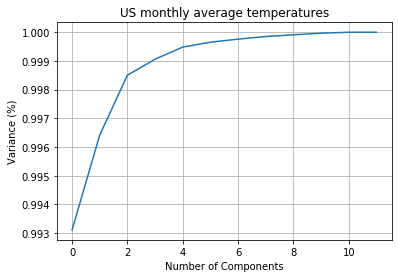

In [22]:
pca = PCA().fit(temps)
#plotting the cumulative summation of the explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('US monthly average temperatures')
plt.grid()
plt.show()

In [23]:
pca.explained_variance_ratio_.round(2)

array([0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

Just 1 new feature obtained from 52 columns explains about 99% of the data variance, so I'll limit all those temperatures from different states to just one column.

In [24]:
pca = PCA(n_components=1)
temps_pca = pca.fit_transform(temps)

In [26]:
temps_pca = pd.DataFrame(temps_pca)
temps_pca.columns = ['US_temp']
temps_pca

US_temp
0   149.463355
1   126.992186
2    75.360065
3    12.736171
4   -54.785704
5  -116.215148
6  -149.008461
7  -139.946106
8   -85.799000
9    -8.021526
10   62.166491
11  127.057678

The dataframe I was looking for can be seen above.

### Data engineering

Since I'm going to merge it with a different dataframe that contains daily data over many years, I'm going to modify it (repeat and rescale from monthly to daily) so later on it can be merged easily.

In [28]:
temps_pca_rep = pd.concat([temps_pca]*20, ignore_index=True)
temps_pca_rep.iloc[[0, 5, 12, 17], :] # checking if rows repeat cyclically

US_temp
0   149.463355
5  -116.215148
12  149.463355
17 -116.215148

In [32]:
temps_pca_rep.index = pd.date_range(start ='2010-01-01', 
                                    periods = 240,
                                    freq ='MS')           # adding monthly index

In [33]:
isinstance(temps_pca_rep.index, pd.DatetimeIndex)

True

In [34]:
temps_pca_rep.head(3)

US_temp
2010-01-01  149.463355
2010-02-01  126.992186
2010-03-01   75.360065

In [36]:
temps_pca_rep = temps_pca_rep.resample('d').ffill()
temps_pca_rep.head(50)[temps_pca_rep.head(50).index.day<4]

US_temp
2010-01-01  149.463355
2010-01-02  149.463355
2010-01-03  149.463355
2010-02-01  126.992186
2010-02-02  126.992186
2010-02-03  126.992186

In [37]:
temps_pca_rep.to_pickle('./Data/temps_pca_rep.pkl') # saving the dataframe as a file that can be accessed
# from other notebooks without scraping the website every time